## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from scipy.optimize import curve_fit

In [3]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.text import Text
import string, re
from nltk.corpus import stopwords

In [4]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

## Load data

The data are contained in 2 different files which have the same columns name. We need to concatenate the 2 files in order to get the full data base.

In [6]:
df_0 = pd.read_csv("winemag-data_first150k.csv") 
df_0.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [7]:
df_1 = pd.read_csv("winemag-data-130k-v2.csv") 
df_1.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


df_1 contains columns that does not exist in df_0. In order to match the 2 data frame, we need to suppress the columns that does not exist into df_0

In [8]:
for column_name in df_1.columns:
    if column_name not in df_0.columns:
        df_1 = df_1.drop(labels=column_name, axis=1)

We can now do the concatenation of the two data frames

In [9]:
df = pd.concat([df_0, df_1])

We supress the column named Unnamed which is not meaningfull

In [10]:
del df['Unnamed: 0']

In [11]:
df.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


We now have our database ready to study

# 1) What are the countries which produce the more different varieties of wine?

In order to see what is the repartition of the production of wines worldwine, we first have a look to the variety of wine grouped by country.

## Data cleaning

Let´s see first how many values are missing in the country column

In [12]:
abs_nan_val = df['country'].isnull().sum()
per_nan_val = abs_nan_val / df.shape[0] * 100
print("There are {} values missing. That represents about {} % of the data".format(abs_nan_val, np.round(per_nan_val, 3)))

There are 68 values missing. That represents about 0.024 % of the data


Let's have a look at the rows with the missing values :

In [13]:
df[df['country'].isnull()]

,country,description,designation,points,price,province,region_1,region_2,variety,winery
1133,NaN,Delicate white flowers and a spin of lemon pee...,Askitikos,90,17.0,NaN,NaN,NaN,Assyrtiko,Tsililis
1440,NaN,"A blend of 60% Syrah, 30% Cabernet Sauvignon a...",Shah,90,30.0,NaN,NaN,NaN,Red Blend,Büyülübağ
68226,NaN,"From first sniff to last, the nose never makes...",Piedra Feliz,81,15.0,NaN,NaN,NaN,Pinot Noir,Chilcas
113016,NaN,"From first sniff to last, the nose never makes...",Piedra Feliz,81,15.0,NaN,NaN,NaN,Pinot Noir,Chilcas
135696,NaN,"From first sniff to last, the nose never makes...",Piedra Feliz,81,15.0,NaN,NaN,NaN,Pinot Noir,Chilcas
913,NaN,"Amber in color, this wine has aromas of peach ...",Asureti Valley,87,30.0,NaN,NaN,NaN,Chinuri,Gotsa Family Wines
3131,NaN,"Soft, fruity and juicy, this is a pleasant, si...",Partager,83,NaN,NaN,NaN,NaN,Red Blend,Barton & Guestier
4243,NaN,"Violet-red in color, this semisweet wine has a...",Red Naturally Semi-Sweet,88,18.0,NaN,NaN,NaN,Ojaleshi,Kakhetia Traditional Winemaking
9509,NaN,This mouthwatering blend starts with a nose of...,Theopetra Malagouzia-Assyrtiko,92,28.0,NaN,NaN,NaN,White Blend,Tsililis
9750,NaN,This orange-style wine has a cloudy yellow-gol...,Orange Nikolaevo Vineyard,89,28.0,NaN,NaN,NaN,Chardonnay,Ross-idi


No obvisous reason why the country is not defined. <br/>
The very low percentage of missing data make us think that we don´t loose general information supressing the rows where the country is not defined.

In [14]:
df = df.dropna(subset=['country'])
n_rows_with_country_missing = df['country'].isnull().sum()
print("There is now {} missing values in the country column".format(n_rows_with_country_missing))

There is now 0 missing values in the country column


## Analyse

Now let´s group the data by country and let´s see the number of wine for each country.

In [15]:
df_countries = df['country'].value_counts() / np.sum(df['country'].value_counts())
df_countries = pd.DataFrame(df_countries)
df_countries = df_countries.rename(columns={"country": "percentage"})
df_countries.index.name = 'country'
df_countries.head();  # Supress ";" to see the result

To represent the production of wine worldwide, we use a library named follium that allows us to plot variables on a map.

In [16]:
import folium

In order to localize the countries on the map we need to use their lattitude and longitude coordinate that we put inside a pandas serie. <br/>
In order to do that, we load another database extract from https://developers.google.com/public-data/docs/canonical/countries_csv

In [17]:
df_countries_coordinates = pd.read_csv("countries_coordinates.txt", encoding="cp1252", sep="\t")
df_countries_coordinates.loc[227, 'name']='US'
df_countries_coordinates.loc[73, 'name']='England'
df_countries_coordinates.loc[140, 'name']='Macedonia'

We add two columns corresponding to the lattitude and longitude of the countries

In [18]:
df_countries["latitude"] = np.nan
df_countries["longitude"] = np.nan

In [19]:
df_countries.tail()

,percentage,latitude,longitude
country,,,
Montenegro,0.000007,NaN,NaN
Japan,0.000007,NaN,NaN
Armenia,0.000007,NaN,NaN
Tunisia,0.000007,NaN,NaN
US-France,0.000004,NaN,NaN


Us-France can't be properly localize ont he wordmap and represent a negligeable fraction of the variety producer of wine so we supress it.

In [20]:
df_countries.drop(labels='US-France', axis=0, inplace=True)

Now, we fill the longitude and latitude coordinate using the second df_countries_coordinates dataframe

In [21]:
for country in df_countries.index:
    df_countries.loc[country]['latitude'] = df_countries_coordinates[df_countries_coordinates['name']==country]['latitude']
    df_countries.loc[country]['longitude'] = df_countries_coordinates[df_countries_coordinates['name']==country]['longitude']

We create te map on which the data will be plotted

In [22]:
m = folium.Map(location=[0,0], titles="Mapbox Bright", zoom_start=2)

In [23]:
small_producers_per = 0
medium_producers_per = 0
big_producers_per = 0
for i in range(0,len(df_countries)):
    if df_countries.iloc[i]['percentage'] < 0.01:
        # small producer producing less than 1 % of the varieties
        small_producers_per += df_countries.iloc[i]['percentage']
        folium.Circle(
          location=[df_countries.iloc[i]['latitude'], df_countries.iloc[i]['longitude']],
          radius=df_countries.iloc[i]['percentage']*2500000,
          color='green',
          fill=True,
          fill_color='green'
       ).add_to(m)
    elif df_countries.iloc[i]['percentage'] >= 0.01 and df_countries.iloc[i]['percentage'] < 0.1:
        # medium producer producing less between 1 % and 10% of the varieties
        medium_producers_per += df_countries.iloc[i]['percentage']
        folium.Circle(
          location=[df_countries.iloc[i]['latitude'], df_countries.iloc[i]['longitude']],
          radius=df_countries.iloc[i]['percentage']*2500000,
          color='orange',
          fill=True,
          fill_color='orange'
       ).add_to(m)
    elif df_countries.iloc[i]['percentage'] >= 0.1:
        # big producer producing more than 10% of the varieties
        big_producers_per += df_countries.iloc[i]['percentage']
        folium.Circle(
          location=[df_countries.iloc[i]['latitude'], df_countries.iloc[i]['longitude']],
          radius=df_countries.iloc[i]['percentage']*2500000,
          color='red',
          fill=True,
          fill_color='red'
       ).add_to(m)
print("Big producers represent {} % of the total number of variety of wine".format(big_producers_per*100))
print("Medium producers represent {} % of the total number of variety of wine".format(medium_producers_per*100))
print("Small producers represent {} % of the total number of variety of wine".format(small_producers_per*100))

Big producers represent 72.32412145296315 % of the total number of variety of wine
Medium producers represent 25.761929687750374 % of the total number of variety of wine
Small producers represent 1.913592775777774 % of the total number of variety of wine


We can now draw the production of each country of this database represented by the area of a circle located at the coordinate of each country on a worldmap

In [24]:
m

In [25]:
m.save('wine_producers.png') # Save of the worldmap

## Conclusion

- 3 main producers which are US, Italy and France producing more than 40%, 15.3% and 15.3% respectively or 72.3% all together. <br/>
- 8 medium producers which are Spain, Chile, Argentina, Portugal, Austria, Germany and South Africaproducing more than 1% each and 25.8% together.
- The rest of the producer represent only 2% of the worldwide production.

What it means for our study is that a customer lambda will rarely meet the wines from the small producer. He will mainly have to deal with the wines from big and medium producers.

# 2a) What are the most used adjectives to describe a wine?

The pupose here is to use Natural Processing Language technics to provide give keywords to the wine chooser so that he can more or less guess if the wine if bad, medium or good.

## Data cleaning

We want here to look at the description of the wines and evaluate the description in function of their grade contained in the column "points"

In [26]:
df.isnull().sum()

country             0
description         0
designation     83189
points              0
price           22687
province            0
region_1        46239
region_2       169369
variety             1
winery              0
dtype: int64

Fortunatelly, there is no missing values in description column nor in point column

## Data preparation

In [27]:
def remove_punctuation(sentence):
    """Remove punctuation from a sentence
    ARGS :
        sentence: sentence (string format)
    OUPUT
        sentence without puntuation (string format)
    """
    sentence = re.sub(r'[^\w\s]', '', sentence)
    return sentence

In [28]:
def remove_stopwords(sentence):
    """Remove stopwords from sentence
    ARGS :
        sentence: sentence (string format)
    OUTPUT :
        sentence without stopwords (string format)
    """
    stop_words = list(set(stopwords.words('english')))
    return [words for words in sentence if not words in stop_words]

In [29]:
def get_most_used_adjectives(full_descriptions):
    """Get the most used adjectives from a string
    ARGS :
        full_description: joined description of the wines (string format)
    OUTPUT:
        
    """
    # The function takes quite a long time because of the length of the description. 
    # We add print command to see the progression of the function
    print("start")
    # Separation of the full description into sentences
    sentences = list(sent_tokenize(full_descriptions))
    print("full descriptions tokenized into sentences")
    # Removing of the punctuation for each sentences
    sentences_no_punct = [remove_punctuation(sentence) for sentence in sentences]
    # Split each sentences sentences into words
    words = [word_tokenize(sentence) for sentence in sentences_no_punct]
    print("full descriptions tokenized into words and punctuation removed")
    # Remove the stopwords
    words_filtered = [remove_stopwords(s) for s in words]
    print("stop words filtered")
    # Identification of the adjectives among the list of words
    adjectives = []
    print("begining of the filtering of adjectives...")
    for n, sentence in enumerate(words):
        POS = nltk.pos_tag(sentence)
        for word, func in POS:
            if func=='JJ':
                adjectives.append(word)
        if n % 10000 == 0:
            print("Progression: ", np.round(100*n/len(words),2), '%  ', "number of adjectives: ", len(adjectives))
    # We join the adjectives into a single string
    adjectives_joined = " ".join(adjectives)
    print("Progression : 100%", "number of adjectives: ", len(adjectives))
    return adjectives_joined
    

## Analysis

In [30]:
full_descriptions = ",".join(df['description'].values).lower()

In [31]:
adjectives_joined = get_most_used_adjectives(full_descriptions)

start


KeyboardInterrupt: 

In [195]:
wordcloud = WordCloud(width=1600, height=800).generate(adjectives_joined)

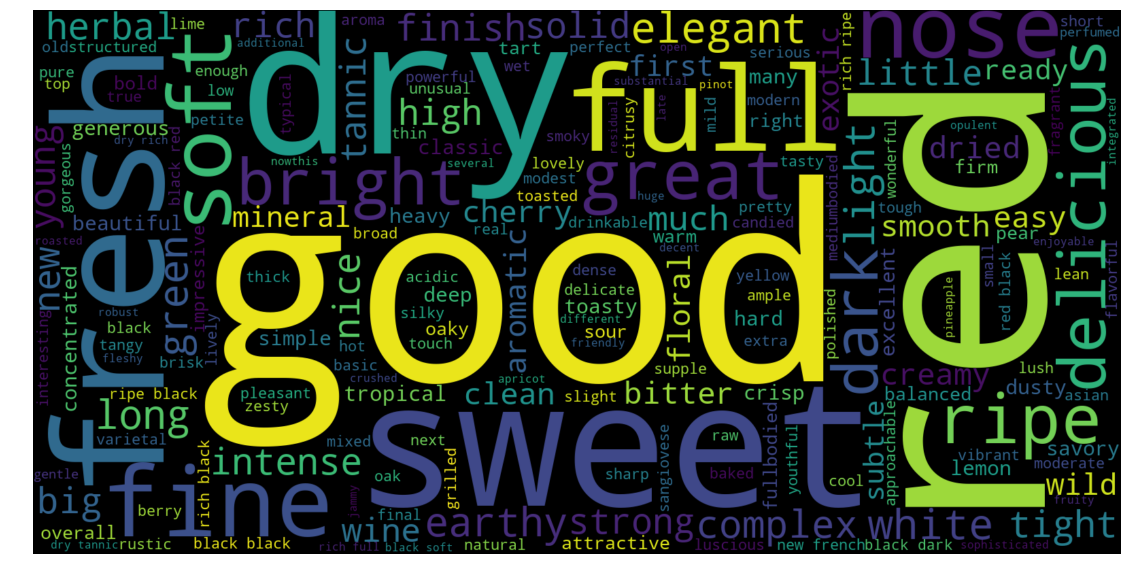

In [196]:
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('adjectives_wine_description.pdf',orientation='portrait',format = 'pdf')

## Conclusion

The picture bellow shows us the most used adjective to describe wine. <br/>
However, we can wonder if the adjective used on the description of the bottle can be used to determined if the wine is good or not.

# 2b) Can we guess if the wine is good or bad just looking at he adjectives employed in the bottle description?

To Answer this question, we need to split the data by grade.

## Data preparation

We group the data by points

In [38]:
df_by_points = df.groupby("points").count()
df_by_points;  # Supress ";" to see the result

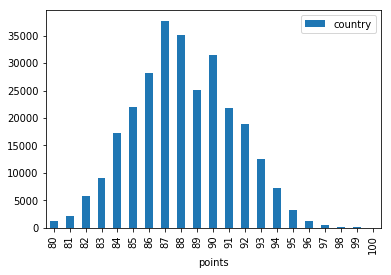

In [39]:
df_by_points.plot.bar(y='country', rot=90);

As it would be maybe too hard to distinguish with accuracy each note with this technic, we split the wines in 3 broader categories :
- Good
- Average
- Bad

To do that, we fit the distribution with a gaussian and use the variance to separate the 3 categories

In [40]:
def gauss_function(x, a, x0, sigma):
    """
    Return the Gaussian distribution of a vector x
    INPUT:
        x : 1D vector
        a : amplitude of the gaussian
        x0 : center of the gaussian
        sigma : variance of the gaussian
    OUTPUT:
        Gaussian distribution of X
    """
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

We fit the data

In [41]:
popt, pcov = curve_fit(gauss_function, df_by_points.index, df_by_points['description'], p0 = [1, 88, 4])
amp, x0, sigma = popt

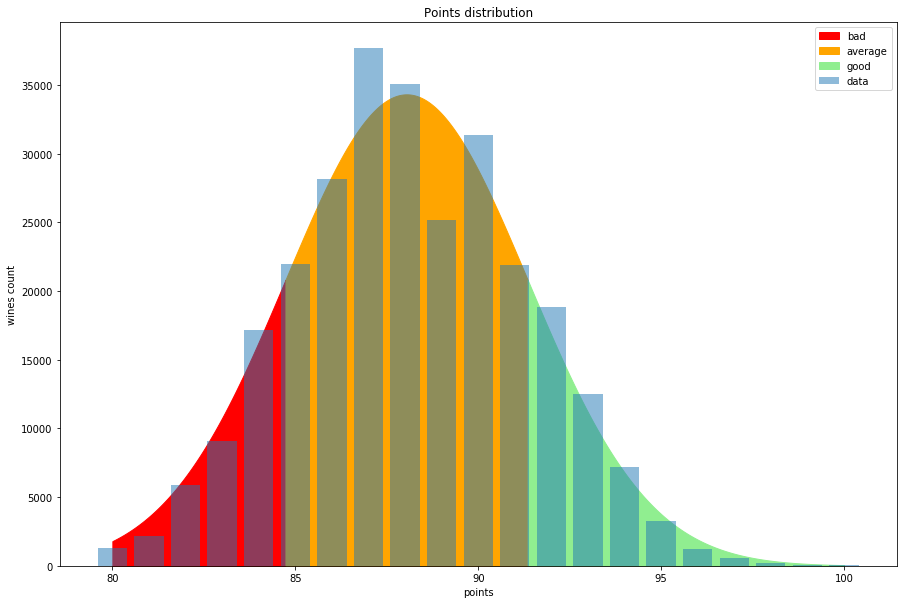

In [50]:
fig, ax = plt.subplots(figsize=(15,10))

ax.bar(df_by_points.index, df_by_points['description'], alpha=0.5, label='data')
x = np.linspace(min(df_by_points.index), max(df_by_points.index), 1000)
ax.set_title('Points distribution');
ax.set_ylabel('wines count');
ax.set_xlabel('points');
x_bad = np.linspace(min(x), x0-sigma, 300)
ax.fill_between(x_bad, gauss_function(x_bad, amp, x0, sigma), color = 'red', label='bad')
x_average = np.linspace(x0-sigma, x0+sigma, 300)
ax.fill_between(x_average, gauss_function(x_average, amp, x0, sigma), color = 'orange', label='average')
x_good = np.linspace(x0+sigma, max(x), 300)
ax.fill_between(x_good, gauss_function(x_good, amp, x0, sigma), color = 'lightgreen', label='good')
ax.legend();
plt.savefig('wines_distribution.png',orientation = 'portrait',format = 'png')

- Bad from 80 to 84
- Average from 85 to 91
- Good from 92 to 100

In [202]:
df_bad = df[df['points']<=84]
df_avg = df[(df['points']>84) & (df['points']<=91)]
df_good = df[df['points']>91]

In [223]:
df_bad_wines_descriptions = ",".join(df_bad['description'].values).lower()
df_avg_wines_descriptions = ",".join(df_avg['description'].values).lower()
df_good_wines_descriptions = ",".join(df_good['description'].values).lower()

In [220]:
bad_adjectives = get_most_used_adjectives(df_bad_wines_descriptions)

start
full descriptions tokenized into sentences
full descriptions tokenized into words and punctuation removed
stop words filtered
begining of the filtering of adjectives...
0.0 %   2
20.9 %   36321
41.8 %   72011
62.69 %   106119
83.59 %   141138


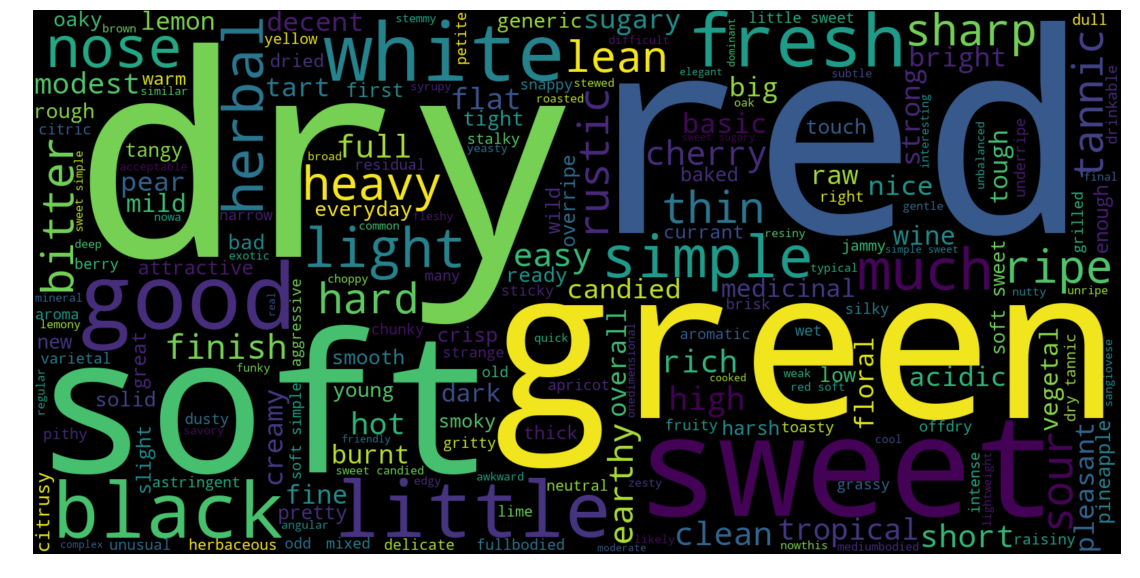

In [226]:
wordcloud_bad = WordCloud(width=1600, height=800).generate(bad_adjectives)
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud_bad, interpolation='bilinear')
plt.axis("off")
plt.savefig('bad_adjectives_wine_description.pdf',orientation='portrait',format = 'pdf')

In [224]:
avg_adjectives = get_most_used_adjectives(df_avg_wines_descriptions)

start
full descriptions tokenized into sentences
full descriptions tokenized into words and punctuation removed
stop words filtered
begining of the filtering of adjectives...
0.0 %   7
2.92 %   33635
5.85 %   66462
8.77 %   100908
11.69 %   136080
14.62 %   170854
17.54 %   205836
20.46 %   240912
23.39 %   273154
26.31 %   305986
29.23 %   341082
32.16 %   376177
35.08 %   410486
38.01 %   446319
40.93 %   479122
43.85 %   513079
46.78 %   548199
49.7 %   579902
52.62 %   608982
55.55 %   641467
58.47 %   675587
61.39 %   709992
64.32 %   744369
67.24 %   778748
70.16 %   812062
73.09 %   845696
76.01 %   879373
78.93 %   913333
81.86 %   947133
84.78 %   981014
87.7 %   1015098
90.63 %   1048932
93.55 %   1082481
96.48 %   1116889
99.4 %   1150553


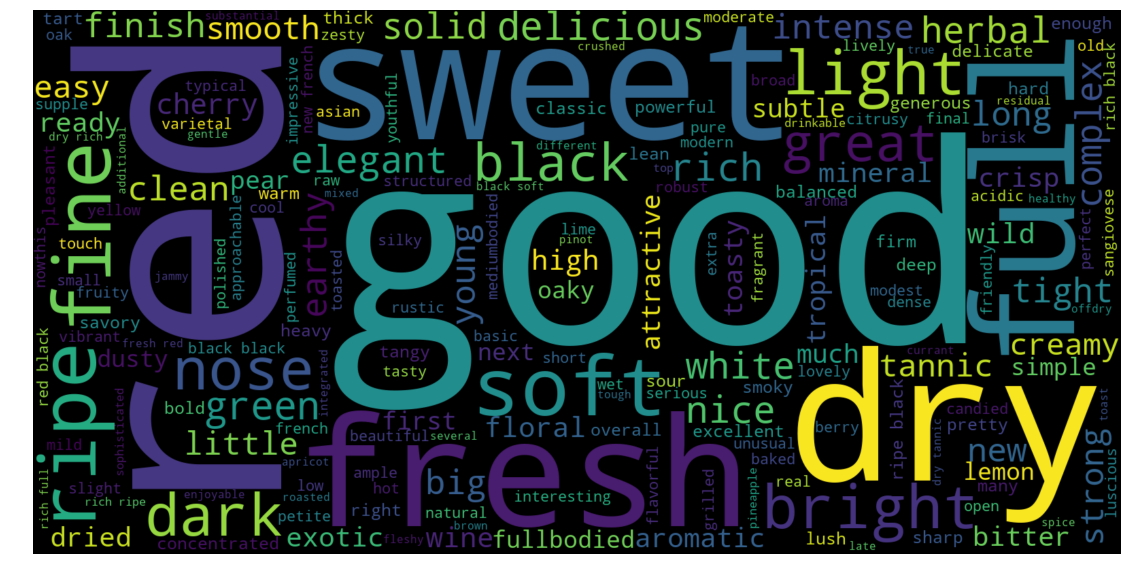

In [225]:
wordcloud_avg = WordCloud(width=1600, height=800).generate(avg_adjectives)
plt.figure(figsize=(20,10) )
plt.imshow(wordcloud_avg, interpolation='bilinear')
plt.axis("off")
plt.savefig('avg_adjectives_wine_description.pdf',orientation='portrait',format = 'pdf')

In [227]:
good_adjectives = get_most_used_adjectives(df_good_wines_descriptions)

start
full descriptions tokenized into sentences
full descriptions tokenized into words and punctuation removed
stop words filtered
begining of the filtering of adjectives...
0.0 %   2
10.04 %   29499
20.08 %   61707
30.13 %   91696
40.17 %   122411
50.21 %   152174
60.25 %   183582
70.3 %   214870
80.34 %   245311
90.38 %   275865


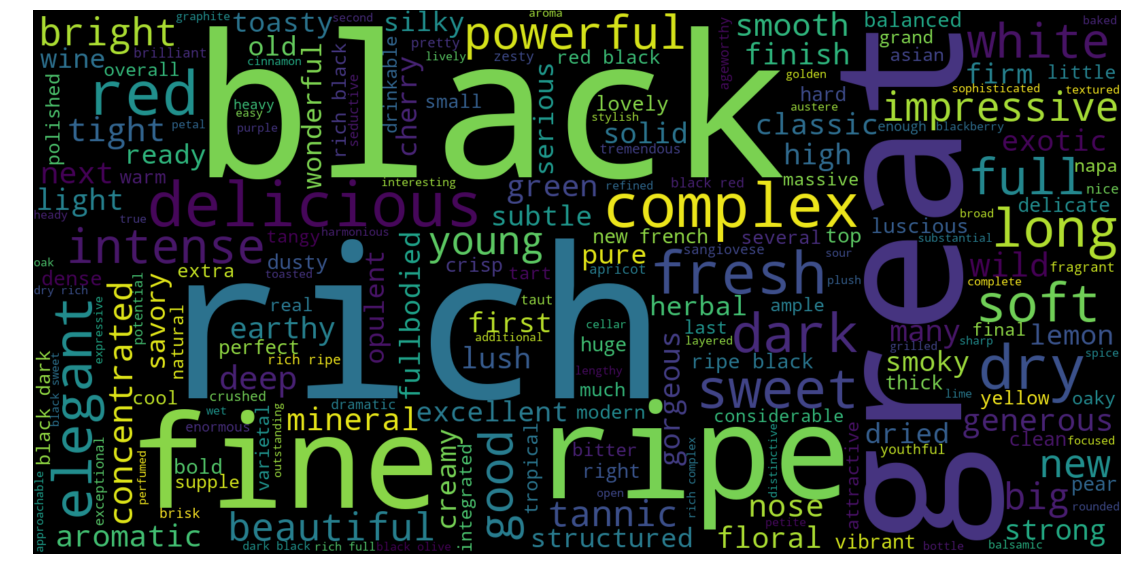

In [228]:
wordcloud_good = WordCloud(width=1600, height=800).generate(good_adjectives)
plt.figure(figsize=(20,10) )
plt.imshow(wordcloud_good, interpolation='bilinear')
plt.axis("off")
plt.savefig('good_adjectives_wine_description.pdf',orientation='portrait',format = 'pdf')

## Conclusion

We see that the frequency of the adjectives employed to describe wines are representative of their quality.

# 2c) Is the length of the description a good indicator of the quality of the wine?

## Data preparation

We add a new column to the database that correspond to the length of the description

In [17]:
df['description_length'] = df['description'].apply(len)

## Analysis

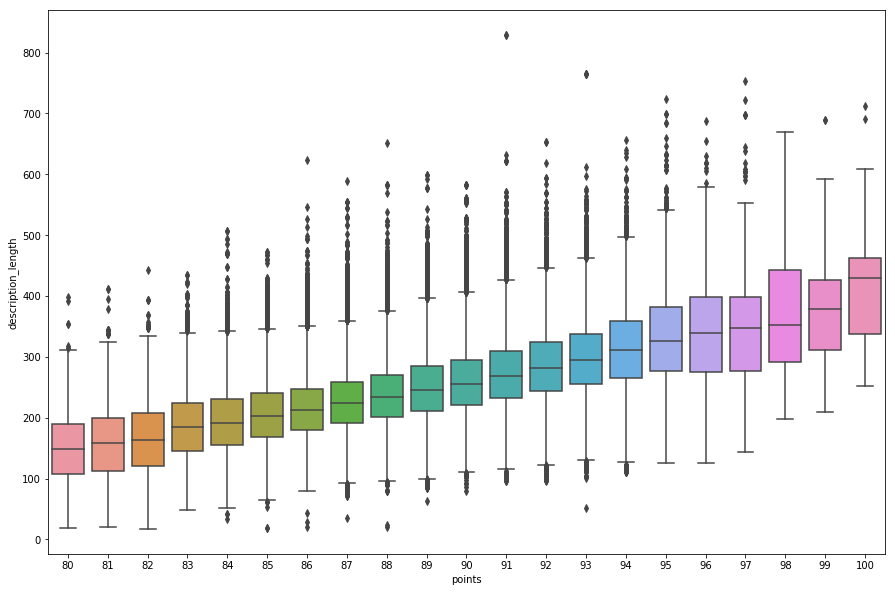

In [57]:
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(x='points', y='description_length', data=df);
plt.savefig('description_length_vs_points_boxplot.png',orientation = 'portrait',format = 'png')

## Conclusion

The length of the description of the length is raising linearly with the points. It is a good indicator of the quality of the wine.

# 3) Rating prediction

We are looking how well we can predict the rating of a wine regarding its price and its description length

## Data preparation

In [13]:
df.isnull().sum()/df.shape[0]*100

country         0.024208
description     0.000000
designation    29.618976
points          0.000000
price           8.077935
province        0.024208
region_1       16.485167
region_2       60.319116
variety         0.000356
winery          0.000000
dtype: float64

No values are missing in points nor the description_lenght columns. <br/>
8% of the values are missing in the price column.

In [14]:
def clean_data(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    Perform to obtain the correct X and y objects
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no points
    2. Create X as all the columns that are not the points column
    3. Create y as the points column
    4. Drop the points, description, region_1, region_2, winery, designation, province, variety, country columns from X
    5. For each numeric variable in X, fill the column with the mean value of the column.
    6. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    # Drop all the rows with no price
    df = df.dropna(subset=['points'], how='any', axis=0)
    
    # Create y as the price column
    y = df['points']
    
    # Create X as all the columns that are not the Salary column
    # Drop the points, description, region_1, region_2, winery, designation, province, variety from columns from X
    df = df.drop(['points', 'description', 'region_1', 'region_2', 'winery', 'designation', 'province', 'variety', 'country'], axis=1)

    #  For each numeric variable in X, fill the column with the mean value of the column.
    num_cols = df.select_dtypes(include=['int', 'float']).columns
    for col in num_cols:
        df[col].fillna((df[col].mean()), inplace=True)
        
    # Create dummy columns for all the categorical variables in X, drop the original columns
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    X = df
    return X, y    

In [15]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

In [18]:
df.corr()['points'] # Correaltion matrix of the dataframe for points (only numeric variable taken into account)

points                1.000000
price                 0.437456
description_length    0.535280
Name: points, dtype: float64

Here, we replace the missing values of the price by the mean value of the prices column and prepare X and y for the linear regression model.

In [19]:
#Use the function to create X and y
X, y = clean_data(df)

## Analysis

In [20]:
# Splitting of the data into test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Linear regression model
lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train, y_train)

# Evaluation of the model
y_test_preds = lm_model.predict(X_test)
print("The r-squared score for the model is {}".format(r2_score(y_test, y_test_preds)))

The r-squared score for the model is 0.3816185081318815


In [21]:
# coefficient value used on the linear regression model
coef_weights(lm_model.coef_, X_train)

,est_int,coefs,abs_coefs
0,price,0.024020,0.024020
1,description_length,0.021571,0.021571


The regression coefficient is not very high even if we have seen that the relation between description length and points has a linear behaviour. What about the price VS points?

# 6) Is the price linear with the quality of the wine?

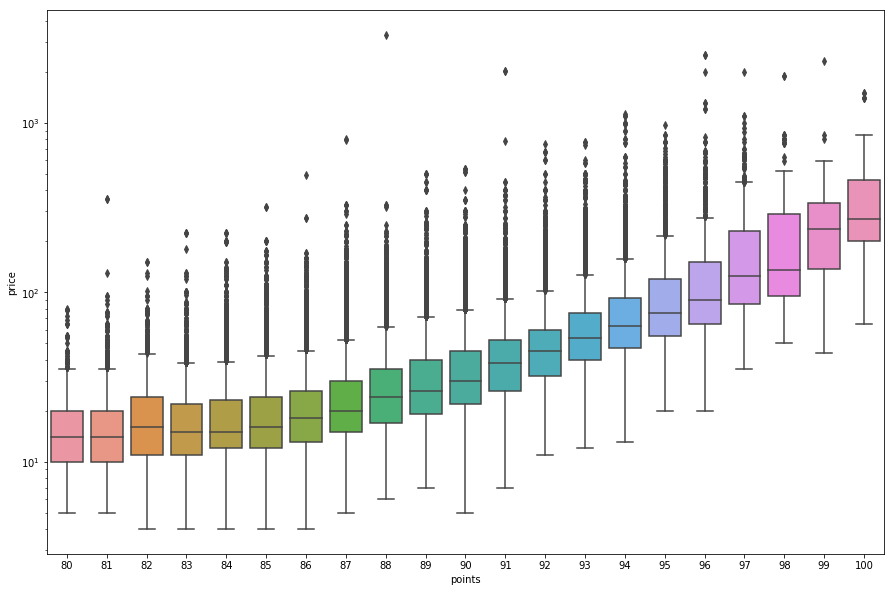

In [22]:
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(x='points', y='price', data=df);
plt.yscale('log')
plt.savefig('points_vs_price_boxplot.png',orientation = 'portrait',format = 'png')

## Conclusion

The price has a non linear behaviour with the quality of the wine which can explain why the linear regression coefficient of the model is not good.

We could improve the quality of the model using a non linear model and taking into account the caterical variables such as the country for example.